In [29]:
# create species annotation class
import libsbml
import numpy as np
import os
import pickle
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline  

PROJ_DIR = "/Users/woosubs/Desktop/AutomateAnnotation/AnnotationRecommender/"
MOD_DIR = os.path.join(PROJ_DIR, "annotation_recommender")
sys.path.append(MOD_DIR)

BIOMD_12 = 'BIOMD0000000012.xml'
BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
ALGO_DIR = os.path.join(DATA_DIR, "algo")
CHEBI_DIR = os.path.join(DATA_DIR, "chebi")
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
BIGG_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")


from annotation_recommender import species_annotation as sa
from annotation_recommender import reaction_annotation as ra
from annotation_recommender import constants as cn
from annotation_recommender import iterator as it
from annotation_recommender import tools

# chebi to shortened formula
with open(os.path.join(CHEBI_DIR, 'chebi_shortened_formula_30apr2022.pickle'), 'rb') as f:
  ref_shortened_chebi_to_formula = pickle.load(f)
# shortened formula to chebi
with open(os.path.join(CHEBI_DIR, 'shortened_formula_to_chebis_20jul2022.pickle'), 'rb') as f:
  ref_shortened_formula_to_chebi = pickle.load(f)

with open(os.path.join(CHEBI_DIR, 'chebi_synonyms.pickle'), 'rb') as f:
  chebi_synonyms = pickle.load(f)
chebi_low_synonyms = dict()
for one_k in chebi_synonyms.keys():
  chebi_low_synonyms[one_k] = list(set([val.lower() for val in chebi_synonyms[one_k]]))

with open(os.path.join(RHEA_DIR, 'kegg2rhea_master.pickle'), 'rb') as handle:
  ref_kegg2rhea_master = pickle.load(handle)
with open(os.path.join(RHEA_DIR, 'kegg2rhea_bi.pickle'), 'rb') as handle:
  ref_kegg2rhea_bi = pickle.load(handle)

# load reference matrix
with open(os.path.join(ALGO_DIR, 'binary_ref_df.pickle'), 'rb') as handle:
    ref_mat = pickle.load(handle)
# check its shape
print(ref_mat.shape)

(13651, 3790)


In [2]:
# specanot = sa.SpeciesAnnotation(libsbml_fpath=ecoli_fpath)
# reacanot = ra.ReactionAnnotation(libsbml_fpath=ecoli_fpath)

# spec_pred_annotations = specanot.predictAnnotationByName(inp_spec_list=None)
# reac_pred_annotations = reacanot.predictAnnotation(inp_spec_dict=specanot.formula,
#                                                    inp_reac_list=None,
#                                                    inp_ref_mat=ref_mat,
#                                                    update=True)

In [3]:
# res = it.iterateAndGetUpdatedResults(spec_cl=specanot,
#                                      reac_cl=reacanot,
#                                      num_iter=10,
#                                      show_message=True)

In [4]:
# print(res['sum_match_score'])

## Evaluate BioModels :) 

In [31]:
# Try one biomodel
one_biomd = 'BIOMD0000000691.xml'
one_biomd_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
species_an = sa.SpeciesAnnotation(libsbml_fpath=one_biomd_fpath)
reaction_an = ra.ReactionAnnotation(libsbml_fpath=one_biomd_fpath)
pred_species = species_an.predictAnnotationByName()
pred_reaction = reaction_an.predictAnnotation(inp_spec_dict=species_an.formula)

In [34]:
model = species_an.model
print([val.name for val in model.getListOfSpecies()])
print("So that's why it couldn't be predicted based on name")

['S1', 'S1', 'S2', 'S2', 'S3', 'S3', 'S4', 'S4', 'N2', 'N2', 'A3', 'A3', 'S4_ex', 'A', 'N', 'N1', 'N1', 'A2', 'A2']
So that's why it couldn't be predicted based on name


In [6]:
res = it.iterateAndGetUpdatedResults(spec_cl=species_an,
                                     reac_cl=reaction_an,
                                     num_iter=10,
                                     show_message=True)

Initial match score: 7.89
*************************
Iteration 1
Updated match score: 8.52
*************************
Iteration 2
Updated match score: 8.52
Score not increasing. Quitting iteration...

Calculation finished.


In [7]:
# Update annotations using res, and compute accuracy; Repeat for all biomodels

In [8]:
print(species_an.getAccuracy(pred_annotation=res['spec_formula']))
print(reaction_an.getAccuracy(pred_annotation=res['candidates']))

0.0
0.0


In [12]:
# Try all biomodels:
biomd_keggs = pd.read_csv(
    os.path.join(BASE_DIR, 'reaction_recommender/reaction_recommender/notebook/biomodels_to_use.csv'),
    index_col=0)
biomodels_to_load = []
for one_idx in biomd_keggs.index:
  if biomd_keggs.loc[one_idx, 'chebi_kegg']:
    biomodels_to_load.append(one_idx)

In [ ]:
iter_nu

In [17]:
res['sum_match_score']

8.523809523809524

In [23]:
res_df = pd.DataFrame(0,
                      index=biomodels_to_load,
                      columns=['spec_accuracy', 'reac_accuracy', 'iter_num', 'match_score'])
for idx, one_biomd in enumerate(biomodels_to_load):
  if idx % 5 == 0:
    print("We are at", idx)
  one_biomd_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
  species_an = sa.SpeciesAnnotation(libsbml_fpath=one_biomd_fpath)
  reaction_an = ra.ReactionAnnotation(libsbml_fpath=one_biomd_fpath)
  pred_species = species_an.predictAnnotationByName()
  pred_reaction = reaction_an.predictAnnotation(inp_spec_dict=species_an.formula)
  res = it.iterateAndGetUpdatedResults(spec_cl=species_an,
                                       reac_cl=reaction_an,
                                       num_iter=5,
                                       show_message=False)
  res_df.loc[one_biomd, 'spec_accuracy'] = species_an.getAccuracy(pred_annotation=res['spec_formula'])
  res_df.loc[one_biomd, 'reac_accuracy'] = reaction_an.getAccuracy(pred_annotation=res['candidates'])
  res_df.loc[one_biomd, 'iter_num'] = res['rep']
  res_df.loc[one_biomd, 'match_score'] = res['sum_match_score']


We are at 0
We are at 5
We are at 10
We are at 15
We are at 20
We are at 25
We are at 30
We are at 35
We are at 40
We are at 45


In [24]:
res_df

,spec_accuracy,reac_accuracy,iter_num,match_score
BIOMD0000000172.xml,0.640000,0.615385,3,14.566667
BIOMD0000000051.xml,0.944444,0.772727,1,41.566667
BIOMD0000000071.xml,0.538462,0.400000,1,11.395238
BIOMD0000000244.xml,0.466667,1.000000,2,65.928571
BIOMD0000000689.xml,0.562500,0.666667,2,6.490476
BIOMD0000000691.xml,0.000000,0.000000,2,8.523810
BIOMD0000000206.xml,1.000000,0.666667,1,7.533333
BIOMD0000000674.xml,0.920000,0.681818,2,48.057143
BIOMD0000000023.xml,0.000000,0.428571,1,7.666667
BIOMD0000000268.xml,0.951220,0.681818,2,40.773810


In [26]:
res_df.to_csv("eval_iter_algorithms.csv")

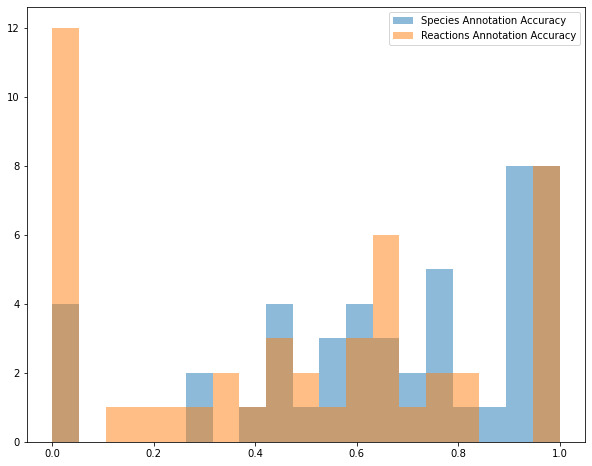

In [30]:
plt.figure(figsize=(10, 8))
bins = np.linspace(0.0, 1.0, 20)
plt.hist(res_df['spec_accuracy'], bins, alpha=0.5, label='Species Annotation Accuracy')
plt.hist(res_df['reac_accuracy'], bins, alpha=0.5, label='Reactions Annotation Accuracy')
plt.legend(loc='upper right')
plt.show()

In [58]:
one_biomd = 'BIOMD0000000248.xml'
one_biomd_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
species_an = sa.SpeciesAnnotation(libsbml_fpath=one_biomd_fpath)
reaction_an = ra.ReactionAnnotation(libsbml_fpath=one_biomd_fpath)

model = species_an.model
print(model.getNumSpecies())
print(model.getNumReactions())
pred_species = species_an.predictAnnotationByName()
pred_reaction = reaction_an.predictAnnotation(inp_spec_dict=species_an.formula)
res = it.iterateAndGetUpdatedResults(spec_cl=species_an,
                                   reac_cl=reaction_an,
                                   num_iter=5,
                                   show_message=False)

9
5


In [63]:
species_an.exist_annotation

{'ATP': ['C10N5O13P3'],
 'PCr': ['C4N3O5P'],
 'ADP': ['C10N5O10P2'],
 'Cr': ['C4N3O2'],
 'Pi': ['O4P'],
 'CFcap': ['O2'],
 'CFtis': ['O2']}

In [61]:
reaction_an.exist_annotation

{'CreatineKinase': ['RHEA:17160']}

In [64]:
one_rid = 'CreatineKinase'
comps = reaction_an.getReactionComponents(one_rid)
print("Species associated with reaction %s:" % one_rid, comps)

Species associated with reaction CreatineKinase: ['PCr', 'ATP', 'ADP', 'Cr']


In [69]:
for one_comp in comps:
  print("For %s in the model, algorithm found %s" % (one_comp, species_an.formula[one_comp]))
  if set(species_an.exist_annotation[one_comp]).intersection(set(species_an.formula[one_comp])):
    print("It was correct")
  print("It wasn't correct!")

For PCr in the model, algorithm found ['C13N2O2', 'C5N.ClCrO3', 'C9N3O8P', 'C22NO2', 'C6Cl5O', 'C17N', 'C6Cl5', 'C5NO2', 'C9N5O3S', 'C34N9O18S4', 'C3', 'Pr', 'C2Cl4', 'Cr', 'C5NO4P', 'C10NO8PR2', 'C18N5O10S2', 'C10N5O3', 'C16N2O4S', 'C21O2', 'C14O5', '(C6O2)n', 'C11N5O3']
It wasn't correct!
For ATP in the model, algorithm found ['C10N5O13P3']
It was correct
It wasn't correct!
For ADP in the model, algorithm found ['C12N3O6', 'C10N5O10P2']
It was correct
It wasn't correct!
For Cr in the model, algorithm found ['C9N5O3S', 'Cr']
It wasn't correct!


In [70]:
species_an.candidates['Cr']

['CHEBI:157802', 'CHEBI:28073']

In [46]:
print(species_an.formula['NADP_c'])
reaction_an.match_score['R7']

['C21N7O17P3']


{'RHEA:10127': 0.5,
 'RHEA:10507': 0.5,
 'RHEA:10651': 0.5,
 'RHEA:10799': 0.5,
 'RHEA:10959': 0.5,
 'RHEA:11059': 0.42857142857142855,
 'RHEA:11423': 0.6,
 'RHEA:11443': 0.6,
 'RHEA:11483': 0.5,
 'RHEA:11651': 0.5,
 'RHEA:11703': 0.5,
 'RHEA:11979': 0.5,
 'RHEA:13464': 0.6,
 'RHEA:13644': 0.5,
 'RHEA:14900': 0.5,
 'RHEA:14956': 0.6,
 'RHEA:15160': 0.5,
 'RHEA:15176': 0.75,
 'RHEA:15720': 0.5,
 'RHEA:15740': 0.5,
 'RHEA:15996': 0.5,
 'RHEA:16388': 0.42857142857142855,
 'RHEA:16756': 0.75,
 'RHEA:17064': 0.5,
 'RHEA:18688': 0.42857142857142855,
 'RHEA:18920': 0.6,
 'RHEA:19360': 0.42857142857142855,
 'RHEA:19460': 0.42857142857142855,
 'RHEA:19480': 0.5,
 'RHEA:19564': 0.5,
 'RHEA:19900': 0.42857142857142855,
 'RHEA:20172': 0.6,
 'RHEA:20392': 0.5,
 'RHEA:20544': 0.6,
 'RHEA:20548': 0.5,
 'RHEA:20923': 0.5,
 'RHEA:21443': 0.42857142857142855,
 'RHEA:21631': 0.5,
 'RHEA:22139': 0.6,
 'RHEA:22207': 0.5,
 'RHEA:22679': 0.5,
 'RHEA:22919': 0.5,
 'RHEA:23219': 0.5,
 'RHEA:23231': 0.6,
 'RHEA